In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "C://Users/esay/data/Stx3/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [8]:

def run_shuffle(sess, rng, last_block_only=False):
    spks = sess.timeseries['spks']
    spks_shuff = np.zeros(spks.shape)
    
    lr = sess.trial_info['LR']
    
    if last_block_only:
        trial_starts = sess.trial_start_inds[sess.trial_info['block_number']==5]
        teleports = sess.teleport_inds[sess.trial_info['block_number']==5]
        
        lr = lr[sess.trial_info['block_number']==5]
    else:
        trial_starts = sess.trial_start_inds
        teleports = sess.teleport_inds
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _spks = 1*spks[:,start:stop]    
        _spks = np.roll(_spks,rng.integers(0,stop-start),axis=-1)
        spks_shuff[:,start:stop] = 1*_spks
        
    tmat = tpu.spatial_analyses.trial_matrix(spks_shuff.T,sess.timeseries['t'].ravel(), trial_starts,
                                                                     teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    nov_mean = np.nanmean(tmat[lr==sess.novel_arm, :, :], axis=0)
    fam_mean = np.nanmean(tmat[lr==-1*sess.novel_arm, :, :], axis=0)
    return nov_mean, fam_mean

def run_shuffle_multi_chan(sess, t, rng):

    F_chan0 = sess.timeseries['channel_0_F_dff']
    F_chan1 = sess.timeseries['channel_1_F_dff']
    
    F_shuff = np.zeros_like(F)
    lr = sess.trial_info['LR']

    trial_starts = sess.trial_start_inds
    teleports = sess.teleport_inds
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F_chan0 = 1*F_chan0[:,start:stop]  
        _F_chan1 = 1*F_chan1[:,start:stop]
        _F_chan0 = np.roll(_F_chan0,rng.integers(0,stop-start),axis=-1)
        _F_chan1 = np.roll(_F_chan1,rng.integers(0,stop-start),axis=-1)
        F_shuff_chan0[:,start:stop] = 1*_F_chan0
        F_shuff_chan1[:,start:stop] = 1*_F_chan1
        
    tmat_chan0 = tpu.spatial_analyses.trial_matrix(F_shuff_chan0.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    tmat_chan1 = tpu.spatial_analyses.trial_matrix(F_shuff_chan1.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    # return np.nanmean(tmat,axis=0)
    
    nov_mean_chan0 = np.nanmean(tmat_chan0[lr==sess.novel_arm, :, :], axis=0)
    nov_mean_chan1 = np.nanmean(tmat_chan1[lr==sess.novel_arm, :, :], axis=0)
    fam_mean_chan0 = np.nanmean(tmat_chan0[lr==-1*sess.novel_arm, :, :], axis=0)
    fam_mean_chan1 = np.nanmean(tmat_chan1[lr==-1*sess.novel_arm, :, :], axis=0)
    return nov_mean_chan0, fam_mean_chan0, nov_mean_chan1, fam_mean_chan1

# shuffle for non-sparse days
rng = np.random.default_rng()
shuff_results = {}
for mice in (ctrl_mice, ko_mice):
    for mouse in mice:
        shuff_results[mouse]={}
        for day in range(5):
            shuff_results[mouse][day] = {}
            sess = u.load_single_day(mouse, day)
            shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, rng) for i in range(100)))
            print(shuff_trial_mat.shape)
            fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
            nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
            shuff_results[mouse][day]['fam']=fam_shuff_thresh
            shuff_results[mouse][day]['nov']=nov_shuff_thresh

    

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
(100, 2, 30, 1381)
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
(100, 2, 30, 1093)
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
(100, 2, 30, 972)
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
(100, 2, 30, 1068)
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
(100, 2, 30, 962)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
(100, 2, 30, 1283)
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
(100, 2, 30, 1170)
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
(100, 2, 30, 1093)
({'da

FileNotFoundError: [Errno 2] No such file or directory: 'C://Users/esay/data/Stx3/YMazeSessPkls\\4467331.2\\roi_aligner_results.pkl'

In [18]:
sparse_mice

('SparseKO_05', 'SparseKO_02', 'SparseKO_03')

In [ ]:
rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}


# F = F_chan0_mask
# starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


In [ ]:
import pickle
if False:
    with open('place_field_shuff_results_block5_only.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [6]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results_SparseKO.pkl','rb') as file:
    shuff_results = pickle.load(file)

In [9]:
shuff_results['SparseKO_05'][0].keys()

dict_keys(['channel_0_left', 'channel_0_right', 'channel_1_left', 'channel_1_right'])

In [6]:
# shuff_results[ctrl_mice[0]][0]['fam']

def get_field_info(mouse, day, ttype):
    if mouse in ctrl_mice:
        cond = 'ctrl'
    else:
        cond = 'cre'
        
    sess = u.load_single_day(mouse, day)
    if ttype == 'fam':
        trial_mask = (sess.trial_info['LR']==-1*sess.novel_arm) * (sess.trial_info['block_number']==5)
    elif ttype == 'nov':
        trial_mask = sess.trial_info['LR'] == sess.novel_arm
    else:
        pass

    # sess.add_pos_binned_trial_matrix('speed')
    speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
    trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
    sig_bins = trial_avg>shuff_results[mouse][day][ttype]

    # eliminate fields that start at first bin of track or end at last bin of track
    field_info = []

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15):
            
            place_field = sess.trial_matrices['spks'][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
            
            speed_field = sess.trial_matrices['speed'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
            
            max_response = np.nanmax(place_field)
            place_field_filt = np.copy(place_field)
            place_field_filt[place_field<.2*max_response] = 0


            place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
            place_field_bin_counts = sp.signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



            thresh_laps = np.zeros(place_field_bool.shape)
            thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

            thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

            field_strength = np.nanmean(place_field,axis=-1)

            if thresh_active_laps.shape[0]>0:


                formation_lap = thresh_active_laps[0][0]
                pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
                if pcnt_trials_active>.66:

                    # cell, left edge, right edge, formation lap, formation lap speed, avg speed
                    field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:]), np.nanmean(speed_field[formation_lap:,:])])
                    
                    
    
    com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fwhm = np.nan*np.zeros([len(field_info)])
    
    # df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
    for c, (cell, l_edge, r_edge, formation_lap, _, _) in enumerate(field_info):
        # print(cell, l_edge, r_edge, formation_lap)

        place_field = sess.trial_matrices['spks'][trial_mask,  l_edge:l_edge+r_edge, cell]
        
        # pos = np.arange(place_field.shape[1])[np.newaxis,:]
        # com = (pos*place_field).sum(axis=1)/(place_field.sum(axis=1)+1E-5)
        # fig,ax = plt.subplots(1,2, sharey=True)
#         # ax[0].imshow(place_field[formation_lap:,:])

        com = []
        # maxact = []
        starts = sess.trial_start_inds[trial_mask]
        stops = sess.teleport_inds[trial_mask]
        for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
            
            pos = sess.timeseries['t'][0,start:stop]
            speed = sess.timeseries['speed'][0, start:stop]
            spks = np.copy(sess.timeseries['spks'][cell,start:stop])
            # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

            mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) & (speed>2)
            if mask.sum()>0:
                pos = pos[mask]
                spks = spks[mask]

                com.append((pos*spks).sum()/(spks.sum()+1E-5))
                # com.append(pos[np.argmax(spks)])
                
            else:
                com.append(np.nan)
                # maxact.append(np.nan)
                
            
        com_mat[:len(com), c] = np.array(com)
        # maxact_mat[:len(maxact),c] = np.array(maxact)
        
#         _com = np.nanmean(com[1:])
        mu_field = np.nanmean(place_field[formation_lap:,:], axis=0)
        field_max = np.amax(mu_field)
        
        cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))
        
        mu_field = (mu_field - cell_min)/(field_max - cell_min)
        
        l = 0
        while mu_field[l]<.5:
            l += 1
        
        
        r = 1
        while mu_field[-r]<.5:
            r += 1
        r -= 1
            
        fwhm[c] = r_edge -l - r


    return field_info, com_mat, fs_mat, fwhm, speed #maxact_mat#, pd.DataFrame(df)



field_stats = {}
df = []
for mouse in (ctrl_mice+ko_mice):
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('fam', 'nov'):
            field_stats[mouse][day][ttype]={}
            
            # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
            field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype)
            # df.append(_df)
            field_stats[mouse][day][ttype]['field_info'] = field_info
            field_stats[mouse][day][ttype]['com'] = com_mat
            field_stats[mouse][day][ttype]['field_strength'] = fs_mat
            # field_stats[mouse][day][ttype]['maxact'] = maxact_mat
            field_stats[mouse][day][ttype]['fwhm'] = fwhm
            field_stats[mouse][day][ttype]['speed'] = speed
            
# df = pd.DataFrame(df)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}


/tmp/ipykernel_133862/820680226.py:112: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', '

/tmp/ipykernel_133862/820680226.py:51: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}


/tmp/ipykernel_133862/820680226.py:112: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'se

/tmp/ipykernel_133862/820680226.py:51: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'sessi

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 

In [7]:
df = {'mouse': [],
      'cond': [],
      'ttype': [],
      'day': [],
      'field_width': [],
      'fwhm': [],
      'n_fields': [],
      'speed': []}
      

lw = 5
s = 10

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice,ko_mice)):
    for mouse in mice:
        for day in range(6):
            for ttype in ('fam', 'nov'):
                df['mouse'].append(mouse)
                df['cond'].append(cond)
                df['ttype'].append(ttype)
                df['day'].append(day)

                f_info = np.array(field_stats[mouse][day][ttype]['field_info'])

                df['field_width'].append(f_info[:,2].mean())
                df['fwhm'].append(field_stats[mouse][day][ttype]['fwhm'].mean())
                
                
                
                cell_list = np.unique(f_info[:,0])
                df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                df['speed'].append(field_stats[mouse][day][ttype]['speed'].mean())
                
df = pd.DataFrame(df)

In [8]:
df.head()

,mouse,cond,ttype,day,field_width,fwhm,n_fields,speed
0,4467331.1,ctrl,fam,0,6.498361,4.679781,1.223262,37.490829
1,4467331.1,ctrl,nov,0,5.960100,4.360765,1.317634,31.184555
2,4467331.1,ctrl,fam,1,7.231222,5.139912,1.184991,38.691379
3,4467331.1,ctrl,nov,1,6.390951,4.604408,1.195562,32.066555
4,4467331.1,ctrl,fam,2,6.478142,4.722678,1.184466,36.500832


[ 60.  60. 120. ...  30.  30.  30.]
[30. 40. 60. ... 30. 30. 30.]
[30. 50. 50. ... 30. 30. 30.]
[60. 30. 50. ... 30. 30. 30.]
[100.  80.  30. ...  30.  30.  30.]
[100.  70.  70. ...  30.  30.  30.]
[ 30. 120. 130. ...  30.  30.  30.]
[ 50.  50. 110. ...  30.  30.  30.]
[90. 30. 30. ... 30. 30. 30.]
[ 50. 100.  70. ...  30.  30.  30.]
[80. 70. 50. ... 30. 30. 30.]
[70. 80. 90. ... 30. 30. 30.]
Familiar ANOVA


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use eit

        Source         SS  DF1  DF2         MS          F     p-unc  \
0         cond  11.569871    1   14  11.569871  13.812680  0.002301   
1          day   1.252327    4   56   0.313082   4.251473  0.004483   
2  Interaction   0.933931    4   56   0.233483   3.170563  0.020320   

   p-GG-corr       np2       eps sphericity  W-spher   p-spher  
0        NaN  0.496632       NaN        NaN      NaN       NaN  
1   0.024287  0.232939  0.642672      False  0.27128  0.042813  
2        NaN  0.184651       NaN        NaN      NaN       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.307435  15.000000   
1          day   -    0     2   True        True -1.504040  15.000000   
2          day   -    0     3   True        True -3.116681  15.000000   
3          day   -    0     4   True        True -2.478464  15.000000   
4          day   -    0     5   True        True -2.295293  15.000000   
5          day   

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "Parametric"] = parametric


      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.247184  15.000000   
1          day   -    0     2   True        True -0.251330  15.000000   
2          day   -    0     3   True        True -1.838222  15.000000   
3          day   -    0     4   True        True -1.267379  15.000000   
4          day   -    0     5   True        True -5.772446  15.000000   
5          day   -    1     2   True        True  1.514130  15.000000   
6          day   -    1     3   True        True -0.453126  15.000000   
7          day   -    1     4   True        True -0.408635  15.000000   
8          day   -    1     5   True        True -6.035915  15.000000   
9          day   -    2     3   True        True -1.676020  15.000000   
10         day   -    2     4   True        True -1.479519  15.000000   
11         day   -    2     5   True        True -6.516548  15.000000   
12         day   -    3     4   True        True  0

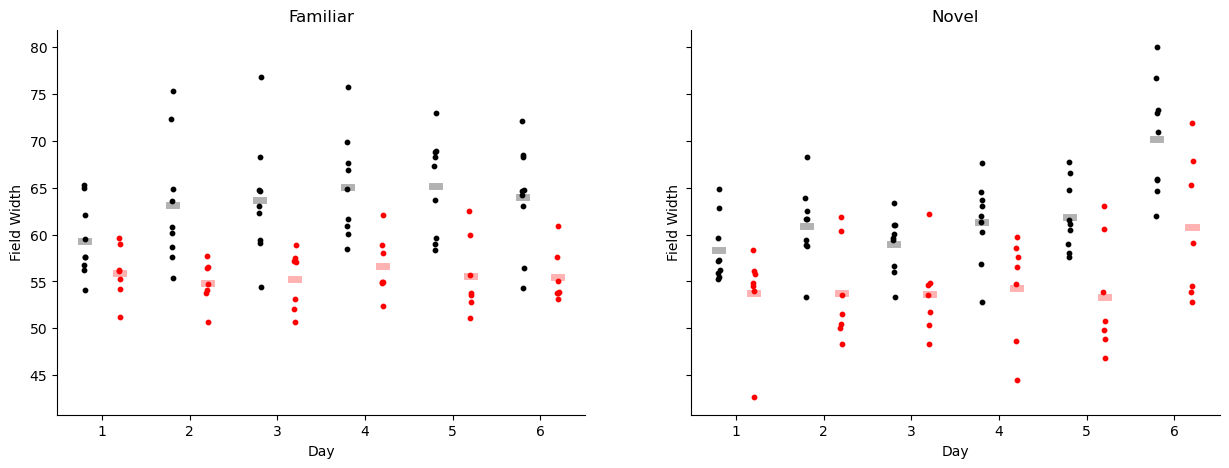

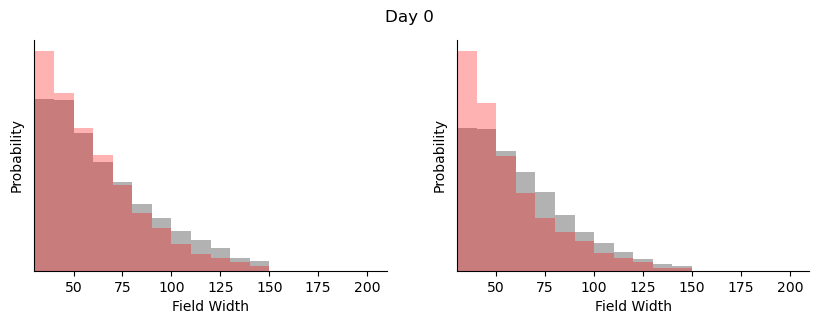

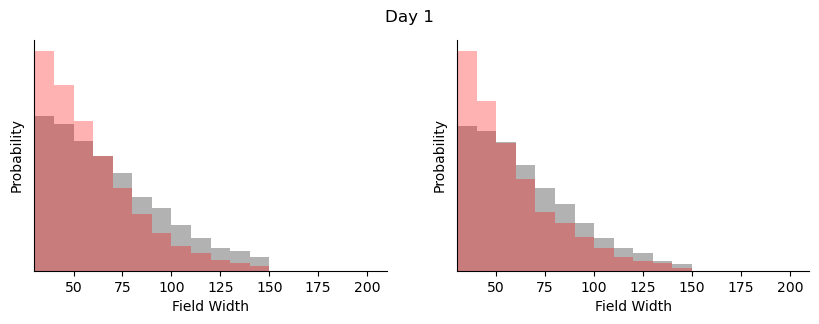

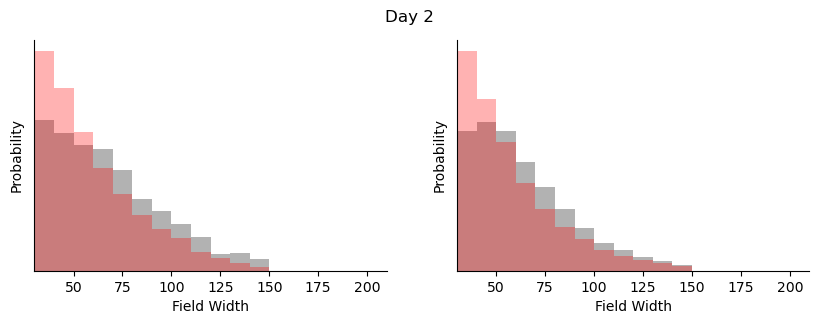

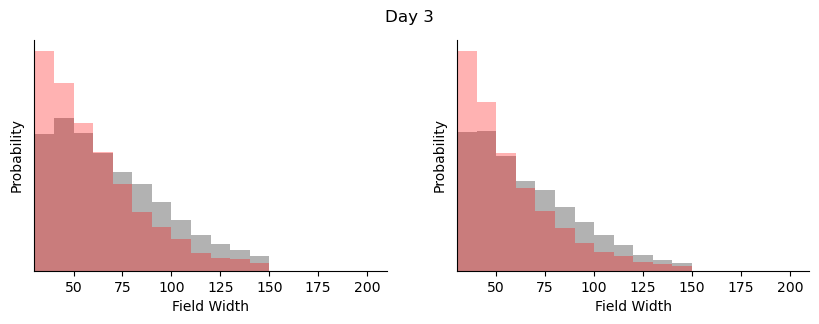

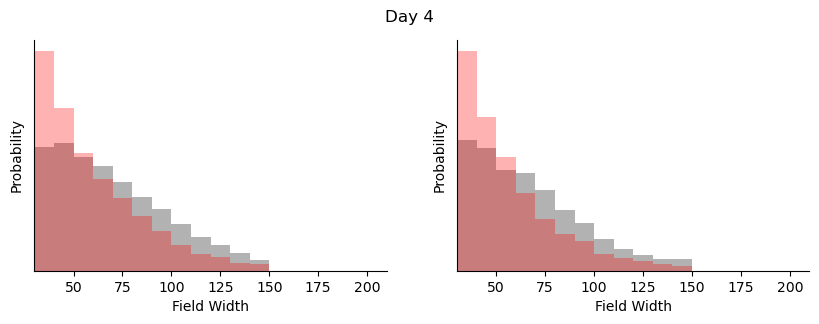

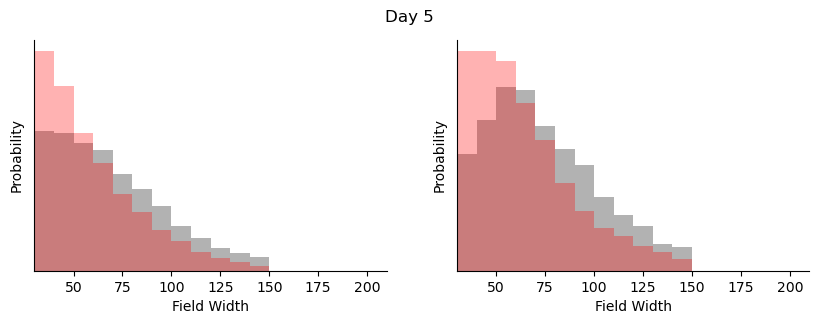

In [9]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))


# single day, across mouse histograms
bin_edges = np.arange(30,210, 10)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ctrl_width.append(f_info[:,2].ravel())
            # ctrl_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ko_width.append(f_info[:,2].ravel())
            # ko_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
            
        ko_width = np.concatenate(ko_width)
        print(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(30,210)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_field_width_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='fam'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='nov'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


Text(0.5, 0, 'Day')

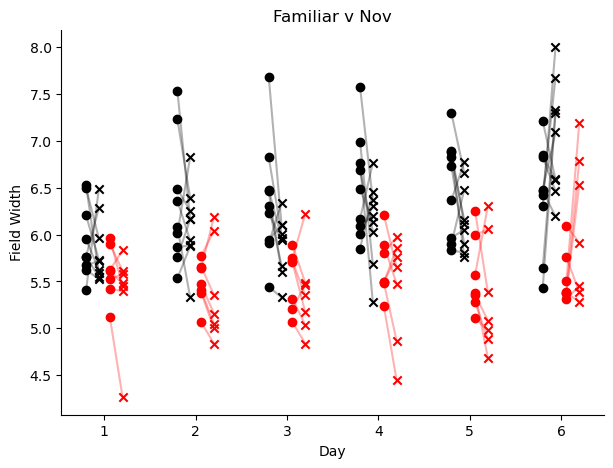

In [10]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"log_activity_rate_summary_within_group.pdf"),format='pdf')

Familiar ANOVA
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0         cond  0.238159    1   14  0.238159  26.415589  0.000150  0.653599   
1          day  0.007941    4   56  0.001985   0.794323  0.533880  0.053691   
2  Interaction  0.034911    4   56  0.008728   3.492326  0.012905  0.199649   

        eps  
0       NaN  
1  0.639672  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.168329  15.000000   
1          day   -    0     2   True        True -0.687721  15.000000   
2          day   -    0     3   True        True -0.788464  15.000000   
3          day   -    0     4   True        True -1.115008  15.000000   
4          day   -    0     5   True        True -0.869163  15.000000   
5          day   -    1     2   True        True  0.726778  15.000000   
6          day   -    1     3   True        True  0.372750  15.000000   
7          day   -    1     

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

      Contrast day    A     B Paired  Parametric          T        dof  \
0          day   -    0     1   True        True   0.247702  15.000000   
1          day   -    0     2   True        True  -0.447787  15.000000   
2          day   -    0     3   True        True  -0.172968  15.000000   
3          day   -    0     4   True        True  -0.138147  15.000000   
4          day   -    0     5   True        True  11.174633  15.000000   
5          day   -    1     2   True        True  -0.770260  15.000000   
6          day   -    1     3   True        True  -0.434213  15.000000   
7          day   -    1     4   True        True  -0.357893  15.000000   
8          day   -    1     5   True        True  10.396137  15.000000   
9          day   -    2     3   True        True   0.354792  15.000000   
10         day   -    2     4   True        True   0.306710  15.000000   
11         day   -    2     5   True        True  12.058511  15.000000   
12         day   -    3     4   True  

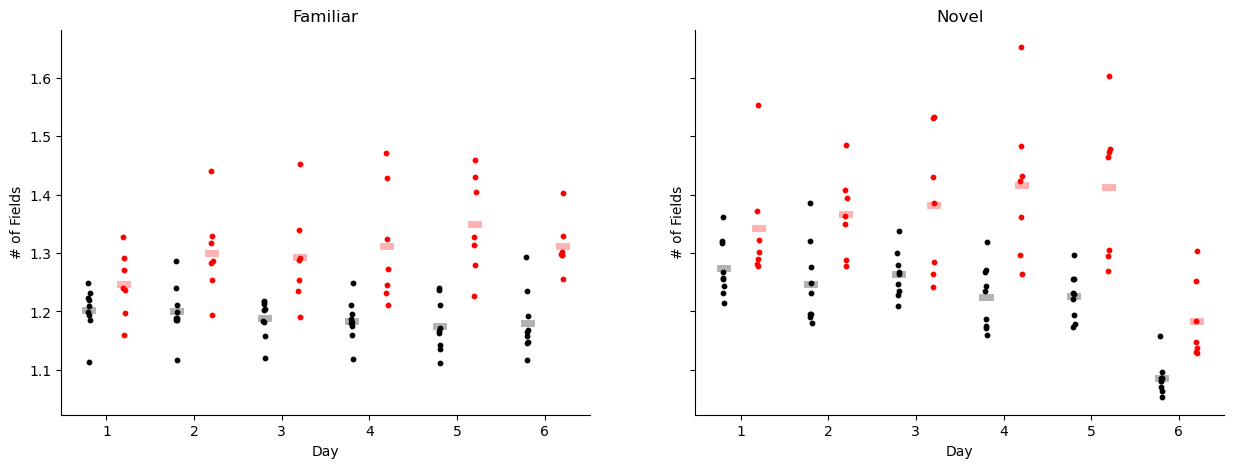

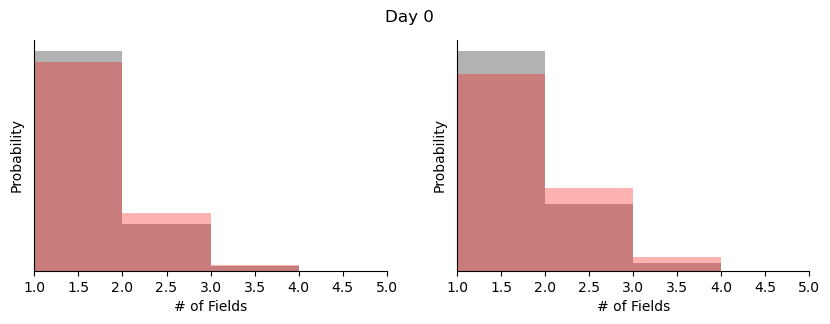

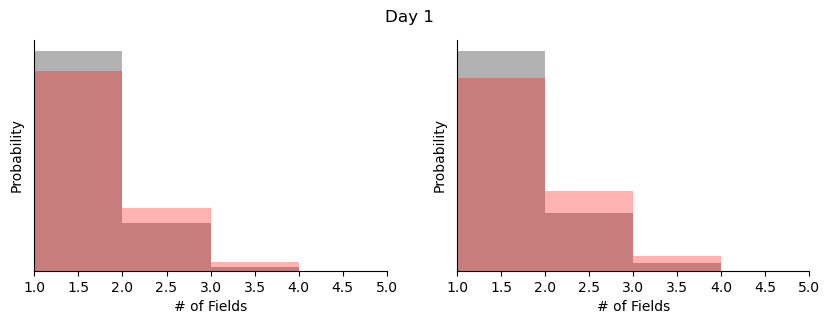

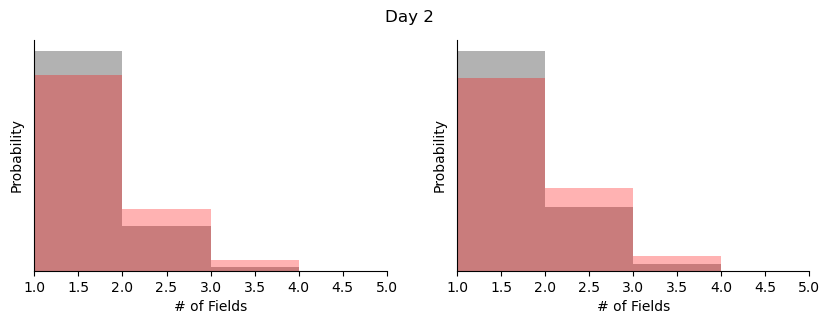

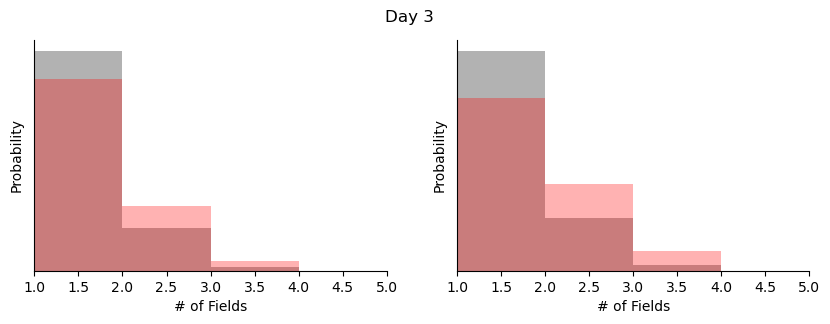

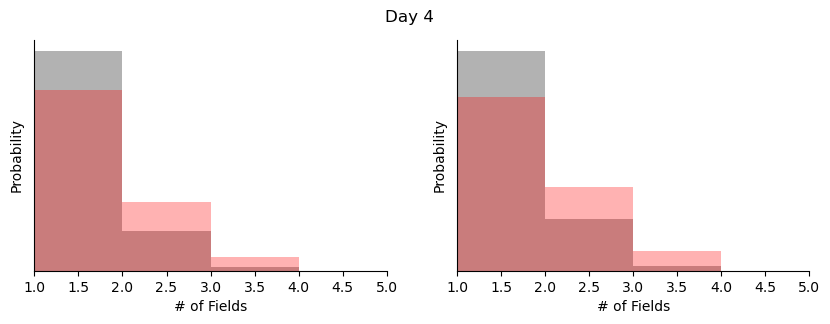

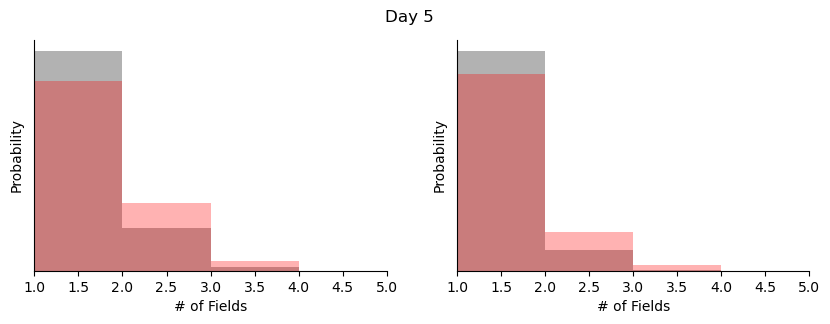

In [13]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))



# single day, across mouse histograms
bin_edges = np.arange(0,5, 1)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
            
            ctrl_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
                
            ko_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
        ko_width = np.concatenate(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('# of Fields')
        ax[ax_ind].set_xlim(1,5)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_num_fields_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='fam')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='nov')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)



Text(0.5, 0, 'Day')

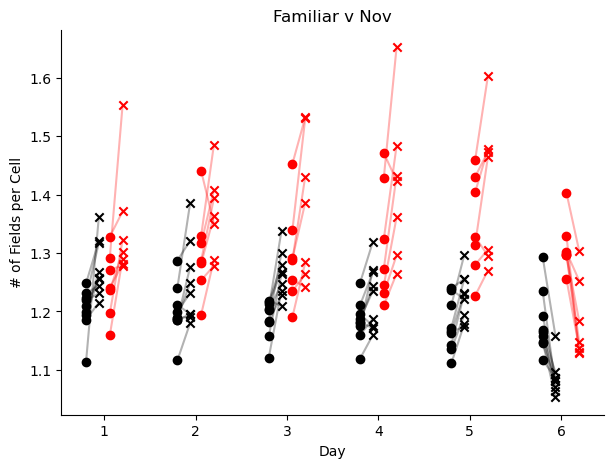

In [12]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('# of Fields per Cell')
ax.set_xlabel('Day')